In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import style

from tpelm import *
from tpelm.bspline import BSpline
from tpelm.tensor_grid import TensorGrid
from tpelm.magnetostatic import DomainState, solve_energy, fit_mag

from sources import m_uniform, flower_state, vortex_state

jax.config.update("jax_enable_x64", True)

# Higher order stray field magnetostatic energy computation

In this notebook, the higher order stray field method is used for magnetostatic energy
computation. 

First we define the `setup` and the `solve` function. `setup` initializes a solver for the respective domain and computes factor matrices to solve the superpotential. The `solve` function computes the
magnetostatic energy. We use the same TPELM for superpotential and magnetization ($r_p=r_p'$) but note that for easy magnetizations (e.g. flower state) we could use a much smaller rank $r'$ which would speed up the computation drastically.

In [ ]:
s = 46
target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(250)

@partial(jax.jit, static_argnames="mag")
def setup(mag, model: BSpline, target_tg: TensorGrid):
    state = DomainState.init(
        sp_elm=model,
        sp_quad_grid=target_tg,
        mag_quad_grid=target_tg,
        target_quad_grid=target_tg,
        gs_terms=s,
        gk_epsabs=1e-13,
        gk_epsrel=0.0,
        gk_order=41,
        gk_max_ninter=50
    )
    mag = fit_mag(state, mag)  # prefit magnetization to functional Tucker format
    return state, mag

@jax.jit
def solve(state: DomainState, mag) -> jax.Array:
    return solve_energy(state, mag)


## Energy for a uniformly magnetized cube

We solve the energy for a uniform magnetization within the unit cube. Theoretically we could set $r'=1$ with $k'=0$ to perfectly fit the magnetization, but we use a much larger rank here for demonstration.

The energy is computed for different ranks $r$ and different B-spline orders $k$. The number of exponential sum terms $S=46$ is used. All fitting procedures use 250 Gauss-Legendre quadrature points for each dimension. This could also be done per spline segment instead to improve accuracy.

In [ ]:
energies_uniform = defaultdict(dict)

# uniform state
e_true = 1 / 6
for k in [3, 4, 5, 6, 7]:
    for r in [5, 10, 15, 20, 25, 30, 35, 40]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(m_uniform, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        energies_uniform[k][r] = e
        err = jnp.abs(e - e_true)
        t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, error={err:.4e}, fitting_time={t.average * 1000:.3f} ms")

k=4, r=5, energy=1.499258e-01, error=1.6741e-02, fitting_time=2.125 ms
k=4, r=10, energy=1.620752e-01, error=4.5915e-03, fitting_time=3.186 ms
k=4, r=15, energy=1.644313e-01, error=2.2354e-03, fitting_time=4.179 ms
k=4, r=20, energy=1.654031e-01, error=1.2636e-03, fitting_time=4.685 ms
k=4, r=25, energy=1.658618e-01, error=8.0483e-04, fitting_time=5.735 ms
k=4, r=30, energy=1.661180e-01, error=5.4863e-04, fitting_time=7.457 ms
k=4, r=35, energy=1.662747e-01, error=3.9192e-04, fitting_time=10.048 ms
k=4, r=40, energy=1.663772e-01, error=2.8943e-04, fitting_time=12.380 ms
k=4, r=45, energy=1.664477e-01, error=2.1899e-04, fitting_time=16.180 ms
k=4, r=50, energy=1.664980e-01, error=1.6869e-04, fitting_time=18.334 ms
k=5, r=5, energy=1.652852e-01, error=1.3815e-03, fitting_time=2.577 ms
k=5, r=10, energy=1.669192e-01, error=2.5252e-04, fitting_time=3.374 ms
k=5, r=15, energy=1.670060e-01, error=3.3931e-04, fitting_time=4.536 ms
k=5, r=20, energy=1.669199e-01, error=2.5327e-04, fitting_time

In [ ]:
e_true = 1 / 6
plt.figure(figsize=(9, 5))

for k in [4, 5, 6, 7, 8, 9]:
    r, e = zip(*list(energies_uniform[k].items()))
    plt.plot([(_r + k - 2)**3 for _r in r], [abs(_e - e_true) for _e in e], "-o", label = f"order {k}")
    
plt.yscale("log")
#plt.xscale("log")
plt.grid(which="both")
plt.legend()
plt.show()

NameError: name 'energies_uniform' is not defined

<Figure size 900x500 with 0 Axes>

In [5]:
k = 7
rs = [10, 20, 30, 40, 50]
energies = []

for r in rs:
    grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
    model = BSpline(grid, degree=k - 1)
    solver, mag = setup(m_uniform, model, target_tg)
    e = solve(solver, mag)
    energies.append(e)
    

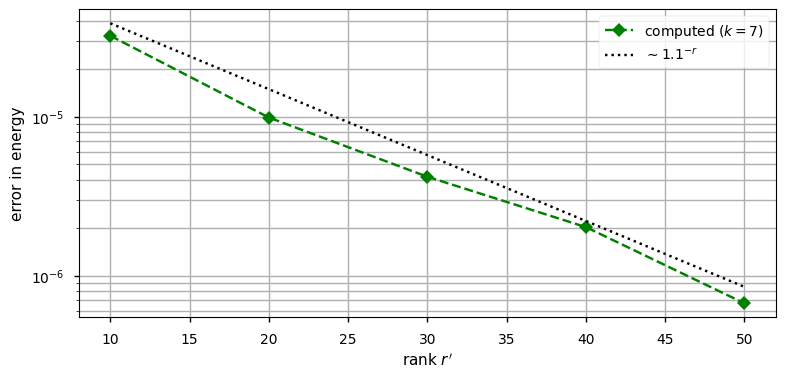

In [7]:
with style.context("seaborn-v0_8-notebook"):
    plt.figure(figsize=(9, 4))
    plt.plot(rs, [jnp.abs(e - 1 / 6) for e in energies], "--D", color="green", label="computed ($k=7$)")
    plt.plot(rs, [1e-4 * 1.1 ** (-_r) for _r in rs], ":", color="k", label=r"$\sim 1.1^{-r}$")
    plt.xlabel("rank $r'$")
    plt.ylabel("error in energy")
    plt.yscale("log")
    plt.grid(axis="x")
    plt.grid(axis="y", which="both")
    plt.legend()
    
plt.show()

## Energy for flower and vortex state

The same energy computation with the same setup is done for a flower and vortex state in the unit cube.

### Flower state:

In [ ]:


energies_flower = defaultdict(dict)
# flower state
for k in [4, 5, 6, 7, 8, 9]:
    for r in [10, 20, 30, 40, 50, 60]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(flower_state, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        energies_flower[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")

k=4, r=10, energy=1.620786e-01, fitting_time=13.295 ms
k=4, r=20, energy=1.654026e-01, fitting_time=19.724 ms
k=4, r=30, energy=1.661148e-01, fitting_time=27.771 ms
k=4, r=40, energy=1.663769e-01, fitting_time=58.204 ms
k=4, r=50, energy=1.664856e-01, fitting_time=90.739 ms
k=4, r=60, energy=1.665609e-01, fitting_time=154.396 ms
k=5, r=10, energy=1.669192e-01, fitting_time=13.181 ms
k=5, r=20, energy=1.669199e-01, fitting_time=19.306 ms
k=5, r=30, energy=1.668206e-01, fitting_time=34.372 ms
k=5, r=40, energy=1.667695e-01, fitting_time=62.831 ms
k=5, r=50, energy=1.667405e-01, fitting_time=92.739 ms
k=5, r=60, energy=1.667222e-01, fitting_time=156.152 ms
k=6, r=10, energy=1.669120e-01, fitting_time=13.484 ms
k=6, r=20, energy=1.667240e-01, fitting_time=19.552 ms
k=6, r=30, energy=1.666923e-01, fitting_time=33.878 ms
k=6, r=40, energy=1.666810e-01, fitting_time=60.958 ms
k=6, r=50, energy=1.666756e-01, fitting_time=107.844 ms
k=6, r=60, energy=1.666724e-01, fitting_time=157.827 ms
k=7, r

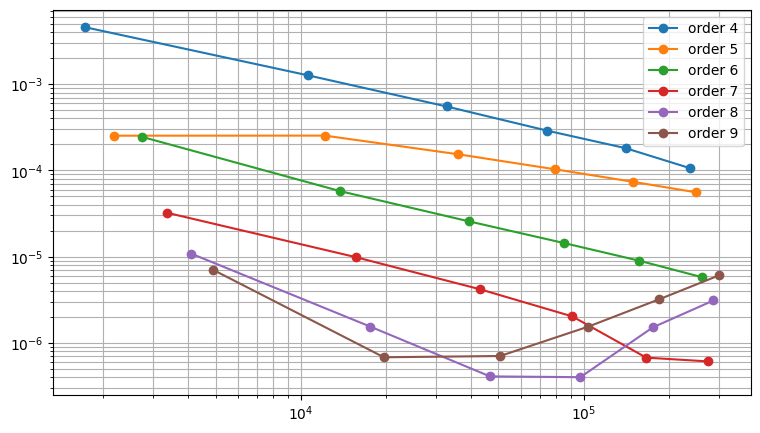

In [51]:
import numpy as np
from scipy.optimize import curve_fit

def _model(h, Einf, C, p):
    return Einf + C * p**(-h)

# h_arr: array of h values, E_arr: array of computed energies
#p0 = [E_arr[-1], E_arr[0]-E_arr[-1], 1.5]  # initial guesses
rs = np.array(list(energies_flower[9].keys()))
es = np.array(list(energies_flower[9].values()))
p0 = [es[-1], 1e-2, -1.5]
params, cov = curve_fit(_model, rs, es, p0=p0, method='trf')
Einf, C, p = params
# uncertainties:
perr = np.sqrt(np.diag(cov))

In [52]:
Einf, C, p, perr

(np.float64(0.15279880665035195),
 np.float64(0.00959435124053349),
 np.float64(-2.4459881828222847),
 array([1.50741507e-06, 4.28632153e+03, 1.09269231e+05]))

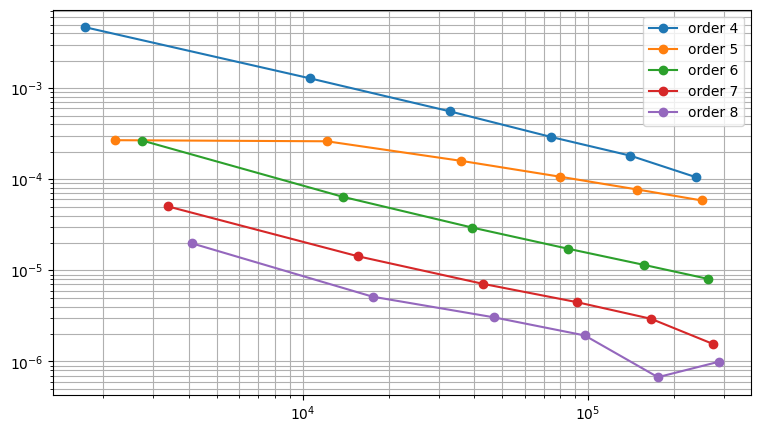

In [ ]:
#e_true_flower = 0.152756
e_true_flower = Einf
plt.figure(figsize=(9, 5))
#for k in energies_flower.keys():
for k in [4, 5, 6, 7, 8]:
    r, e = zip(*list(energies_flower[k].items()))
    plt.plot([(_r + k - 2)**3 for _r in r], [abs(_e - e_true_flower) for _e in e], "-o", label = f"order {k}")
    
plt.yscale("log")
plt.xscale("log")
plt.grid(which="both")
plt.legend()
plt.show()

### Vortex state:

In [95]:
energies_vortex = defaultdict(dict)

# vortex state
for k in [4, 5, 6, 7, 8, 9]:
    for r in [10, 20, 30, 40, 50, 60, 70, 80]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(vortex_state, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        energies_vortex[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")

k=4, r=10, energy=1.839140e-02, fitting_time=13.520 ms
k=4, r=20, energy=2.083909e-02, fitting_time=20.609 ms
k=4, r=30, energy=2.134449e-02, fitting_time=30.545 ms
k=4, r=40, energy=2.153675e-02, fitting_time=69.733 ms
k=4, r=50, energy=2.163001e-02, fitting_time=107.246 ms
k=4, r=60, energy=2.168215e-02, fitting_time=174.848 ms
k=4, r=70, energy=2.171414e-02, fitting_time=412.651 ms
k=4, r=80, energy=2.173513e-02, fitting_time=664.927 ms
k=5, r=10, energy=2.138978e-02, fitting_time=13.622 ms
k=5, r=20, energy=2.189366e-02, fitting_time=20.386 ms
k=5, r=30, energy=2.187466e-02, fitting_time=37.287 ms
k=5, r=40, energy=2.185373e-02, fitting_time=67.782 ms
k=5, r=50, energy=2.183952e-02, fitting_time=108.503 ms
k=5, r=60, energy=2.182993e-02, fitting_time=179.229 ms
k=5, r=70, energy=2.182323e-02, fitting_time=586.573 ms
k=5, r=80, energy=2.181837e-02, fitting_time=836.126 ms
k=6, r=10, energy=2.331356e-02, fitting_time=17.182 ms
k=6, r=20, energy=2.184117e-02, fitting_time=26.448 ms
k=

2025-11-07 15:12:00.335164: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.61GiB (rounded to 6019645952)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-11-07 15:12:00.336892: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ***___________________________________________________*_____*_______________________________________
E1107 15:12:00.336929   32809 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6019645944 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6019645944 bytes.

## Vortex state in a thin film

For other domains, such as a thin film $[-0.5, 0.5]\times [-0.5, 0.5] \times [-0.05, 0.05]$ we need to adjust the spline model and the quadrature tensor grid. As a reference we have $e_d=0.001562$ computed by *mumax3*.

In [ ]:
# thin film
energies_thin_film = defaultdict(dict)

target_tg = TensorGrid(
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.05, 0.05]),
).to_gauss((250, 250, 50))


for k in [4, 5, 6, 7, 8]:
    for r in [20, 40, 60]:
        grid = TensorGrid(
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.05, 0.05, r // 4)
        )
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(vortex_state, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        energies_thin_film[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")